In [3]:
!pip install lifetimes
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00


In [4]:
df = pd.read_csv('/content/Online_Retail.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
df = df[df['Quantity'] > 0 ]
df = df[df['UnitPrice'] > 0]
df = df[~df['InvoiceNo'].str.contains("C",na=False)]

In [9]:
df.dropna(inplace=True)

In [10]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):



    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [11]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

In [12]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,8.348212,2.651029,15552.486392
std,9.245021,2.248187,1594.527150
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,36.000000,8.500000,18287.000000


In [13]:
df = df[df.Country == 'United Kingdom']

In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')
clv = clv[clv['frequency']>1]
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
12823.0,4.0,222.0,296.0,252.450000


In [18]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1738 subjects, a: 0.00, alpha: 112.07, b: 0.00, r: 2.38>

In [19]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.381731e+00,1.013873e-01,2.183012e+00,2.580451e+00
alpha,1.120749e+02,5.267568e+00,1.017504e+02,1.223993e+02
a,2.301100e-14,3.668679e-10,-7.190381e-10,7.190841e-10
b,2.398753e-05,3.819724e-01,-7.486418e-01,7.486898e-01


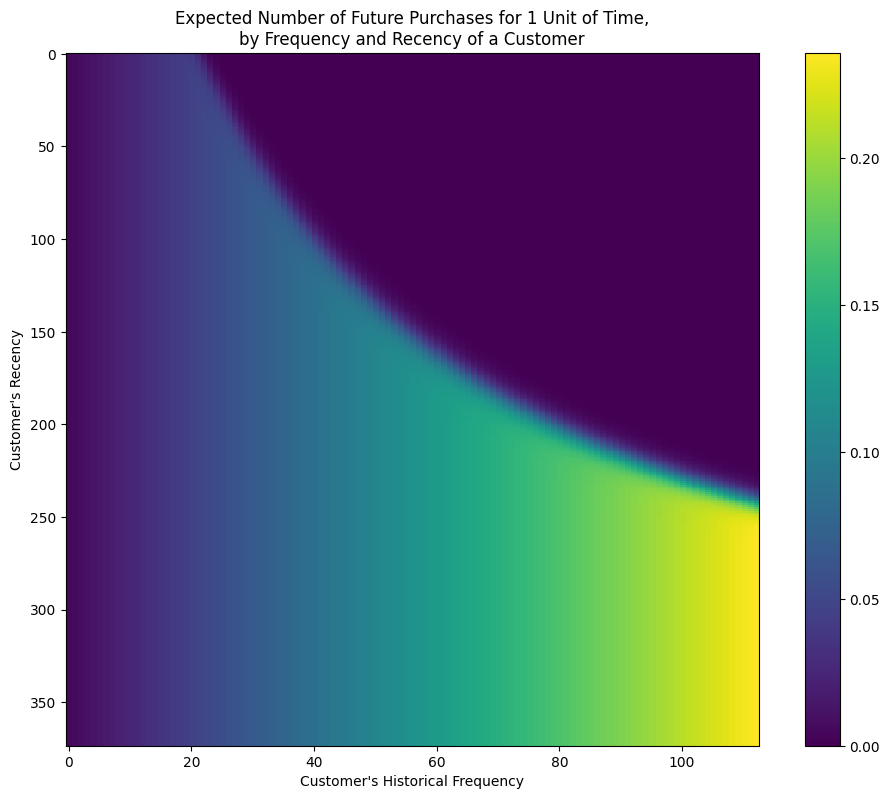

In [20]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

In [21]:
t = 180
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
12748.0,112.0,373.0,373.0,257.314911,42.444401
17841.0,111.0,372.0,373.0,349.079640,42.073324
15311.0,89.0,373.0,373.0,421.881573,33.909635
14606.0,88.0,372.0,373.0,125.302955,33.538559
12971.0,70.0,369.0,372.0,132.197571,26.914663


In [22]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.082631
monetary_value,0.082631,1.000000


In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1738 subjects, p: 3.80, q: 0.35, v: 3.73>

In [24]:
clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)

In [25]:
clv.sort_values('6_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
CustomerID,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,15.528400,45677.610915
18102.0,25.0,367.0,367.0,2112.843200,10.287978,21142.592872
13089.0,65.0,367.0,369.0,784.818308,25.211693,19164.137958
17511.0,27.0,371.0,373.0,1798.113704,10.902877,19058.975876
14088.0,11.0,312.0,322.0,3352.988182,5.549070,18258.492844


In [26]:
clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])
clv.head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV,Segment
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,375.725000,4.632775,1712.381633,Champions
12748.0,112.0,373.0,373.0,257.314911,42.444401,10566.853327,Champions
12749.0,3.0,210.0,213.0,999.106667,2.979965,3054.158128,Champions
12820.0,3.0,323.0,326.0,256.573333,2.211293,584.100407,Need Attention
12823.0,4.0,222.0,296.0,252.450000,2.814953,719.842220,Need Attention


In [27]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737


In [28]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737
